In [1]:
import torch
import sys
sys.path.append('../')
import time
from ttpi import TTPI 
from dyn_models.pushing_dyn_ttpi import pusher_slider_sys
torch.set_default_dtype(torch.float64)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
p_target = torch.tensor([0., 0., 0.]).view(1,-1).to(device)
dt=0.025

dyn_system =  pusher_slider_sys(p_target=p_target,dt=dt, device=device)
dyn_system_test =  pusher_slider_sys(p_target=p_target,dt=dt, device=device)

In [4]:
# dim=5
w = 0.5
state_max_c = torch.tensor([w,w,torch.pi, -0.065, 0.06]).to(device) # (s_x, s_y, s_theta, p_x, p_y) 
state_min_c =  torch.tensor([-w,-w,-torch.pi, -0.1, -0.06]).to(device)

state_max = torch.tensor([w,w,torch.pi, -0.065, 0.06, 3]).to(device) # (s_x, s_y, s_theta, p_x, p_y, face_id) 
state_min =  torch.tensor([-w,-w,-torch.pi, -0.1, -0.06, 0]).to(device)
is_state_c = torch.tensor([1]*len(state_max)).to(device)
is_state_c[-1] = 0

n = 100
n_state = [n]*5
n_state[2] = 100
n_action = 50

v = 0.1
action_max_c = torch.tensor([v, v]).to(device) # (p_ddx, p_ddy)
action_min_c = torch.tensor([0, -v]).to(device)
action_max =  torch.tensor([v,v,3]).to(device)
action_min = torch.tensor([0,-v,0]).to(device)

In [5]:
domain_state_c = []
for i in range(len(state_max_c)):#x,dx
    x_n = torch.linspace(state_min_c[i],0,int(n_state[i]/2)).to(device)
    x_p = torch.linspace(0,state_max_c[i],int(n_state[i]/2)).to(device)[1:]
    domain_state_c.append(torch.concat((x_n,x_p),dim=-1))
domain_state = domain_state_c  +[torch.tensor([0.,1.,2.,3.]).to(device)]
domain_action = [torch.tensor([0.,1.,2.,3.]).to(device)]+ [torch.linspace(action_min_c[i],action_max_c[i],n_action).to(device) for i in range(len(action_max_c))]

In [6]:
def forward_model(state,action):
    next_state = dyn_system.dynamics(state,action)
    return next_state


def reward(state,action):
    rewards = -1*dyn_system.cost_func(state,action,scale=w)
    return rewards

In [7]:
n_test = 100
dim_state = len(domain_state)
init_state = torch.empty((n_test,dim_state))
for i in range(dim_state):
    init_state[:,i] = state_min[i] + torch.rand(n_test).clip(0.25,0.75).to(device)*(state_max[i]-state_min[i])
state = init_state.to(device)


In [8]:
tol = torch.tensor([0.03, 0.03, 15/180*torch.pi]).to(device)[:3]

def callback(ttpi, state=state, file_name='fig',callback_count=0):
    print("Testing....")
    
    history = []
    T=2000
    traj = state[:,:].clone()[:,None,:] #bsx(T+1)x6
    traj_actions = torch.empty(state.shape[0],T,3).to(device) #bsxTx3
    cum_reward = torch.tensor([0.]*state.shape[0]).to(device)
    dt_cum = 0
    for i in range(T):
        t0 = time.time()
        
        action = ttpi.policy(state)
        # print(action[0,0])
        t1=time.time()
        dt_cum+=(t1-t0)
        r = ttpi.reward_normalized(state,action)
        cum_reward+=r
        state = forward_model(state,action)
        traj = torch.concat((traj,state[:,None,:]),dim=1)
        traj_actions[:,i,:]=action
    print("time taken by policy: ", dt_cum/T)
    succ_rate = torch.sum(torch.all(torch.abs(state[:,:3])<=tol, dim=1))/n_test
    print(f"Success rate of {n_test} tests is {succ_rate*100}%")
    print(traj_actions[0,:,0])
    from plot_utils import plot_planarpush

    plot_num = 99 # number of plotted tasks
    plt=plot_planarpush(traj[-plot_num:].to('cpu').numpy(),
                        traj_actions[-plot_num:].to('cpu').numpy(), 
                        animation=False, step_skip=40, 
                        xmax=w,x_target=p_target[0].to('cpu').numpy(),figsize=5, 
                        save_as=None,
                        scale=10)
    plt.show()        
    return r.mean().to("cpu"), cum_reward.mean().to("cpu")
    

In [9]:
ttpi = TTPI(domain_state=domain_state, 
                domain_action=domain_action, 
                reward=reward, 
                normalize_reward=False,
                forward_model=forward_model, 
                gamma=0.99, 
                rmax_v=100, rmax_a=100, 
                nswp_v=5, nswp_a=5, 
                kickrank_v=10, kickrank_a=20,
                max_batch_v=10**4,max_batch_a=10**5,
                eps_cross_v=1e-3,
                eps_cross_a=1e-3,
                eps_round_v=1e-4, 
                eps_round_a=1e-3, 
                n_samples=10, 
                verbose=True, 
                device=device) # action = 'deterministic_tt', 'stochastic_tt', 'random'

#############################################################################
Learning begins
#############################################################################
Computing reward function in TT format for normalization
cross device is cuda
Cross-approximation over a 9D domain containing 3.80396e+14 grid points:
iter: 0 | eps: 2.167e-01 | time:   0.1657 | largest rank:   1
iter: 1 | eps: 3.161e-05 | time:   0.3161 | largest rank:  21 <- converged: eps < 0.0001
Did 406792 function evaluations, which took 0.1154s (3.524e+06 evals/s)

Rank of reward:  tensor([1, 8, 4, 5, 5, 6, 8, 3, 3, 1])
Initialize policy (q-fcn) by random initialization of value-function....
Testing....
time taken by policy:  0.0025102282762527466
Success rate of 100 tests is 0.0%
tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')



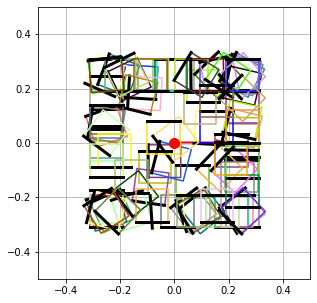

Memory:  0.000726016 0.847249408
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Policy Iteration 1/30
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Number of value updates:  1
.....................................................
Computing Advantage Fcn
.....................................................
v_min: -1.21, v_mean: -0.64, v_max: -0.01
a_min: -121.69, a_mean: -64.65, a_max: -0.65
p_min: 122.04, p_mean: 179.08, p_max: 243.08
Rank of V-model:  tensor([1, 4, 2, 2, 2, 1, 1])
Rank of A-model:  tensor([1, 4, 2, 3, 3, 5, 6, 3, 2, 1])
Rank of P-model:  tensor([1, 6, 4, 5, 5, 7, 8, 5, 4, 1])
--------------------------------------------
Time taken:1.6762628555297852
--------------------------------------------
Memory:  0.000506368 0.006291456000000001
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Policy Iteration 2/30
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Number of value updates:  1
.....................................................
Computing Advantage Fcn
.............................

.....................................................
Computing Advantage Fcn
.....................................................
v_min: -5.93, v_mean: -3.13, v_max: -0.03
a_min: -122.28, a_mean: -64.62, a_max: -0.16
p_min: 123.11, p_mean: 180.77, p_max: 245.23
Rank of V-model:  tensor([ 1, 16,  9,  3,  2,  2,  1])
Rank of A-model:  tensor([1, 6, 4, 6, 7, 7, 9, 4, 3, 1])
Rank of P-model:  tensor([ 1,  8,  6,  8,  9,  9, 11,  6,  5,  1])
--------------------------------------------
Time taken:4.382251501083374
--------------------------------------------
Memory:  0.000976896 0.006291456000000001
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Policy Iteration 6/30
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Number of value updates:  1


.....................................................
Computing Advantage Fcn
.....................................................
v_min: -7.09, v_mean: -3.73, v_max: -0.03
a_min: -123.15, a_mean: -64.63, a_max: 1.09
p_min: 125.24, p_mean: 183.76, p_max: 249.48
Rank of V-model:  tensor([ 1, 13,  6,  3,  2,  2,  1])
Rank of A-model:  tensor([ 1,  6,  4,  6,  8,  9, 11,  6,  4,  1])
Rank of P-model:  tensor([ 1,  8,  6,  8, 10, 11, 13,  8,  6,  1])
--------------------------------------------
Time taken:5.186214923858643
--------------------------------------------
Memory:  0.001024512 0.006291456000000001
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Policy Iteration 7/30
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Number of value updates:  1
.....................................................
Computing Advantage Fcn
.....................................................
v_min: -8.22, v_mean: -4.33, v_max: -0.04
a_min: -123.13, a_mean: -64.61, a_max: 1.06
p_min: 125.19, p_mean: 183.71, p_

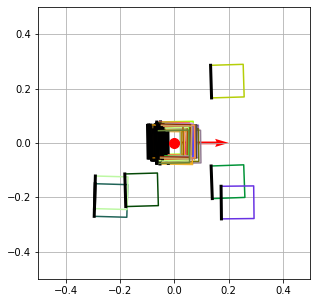

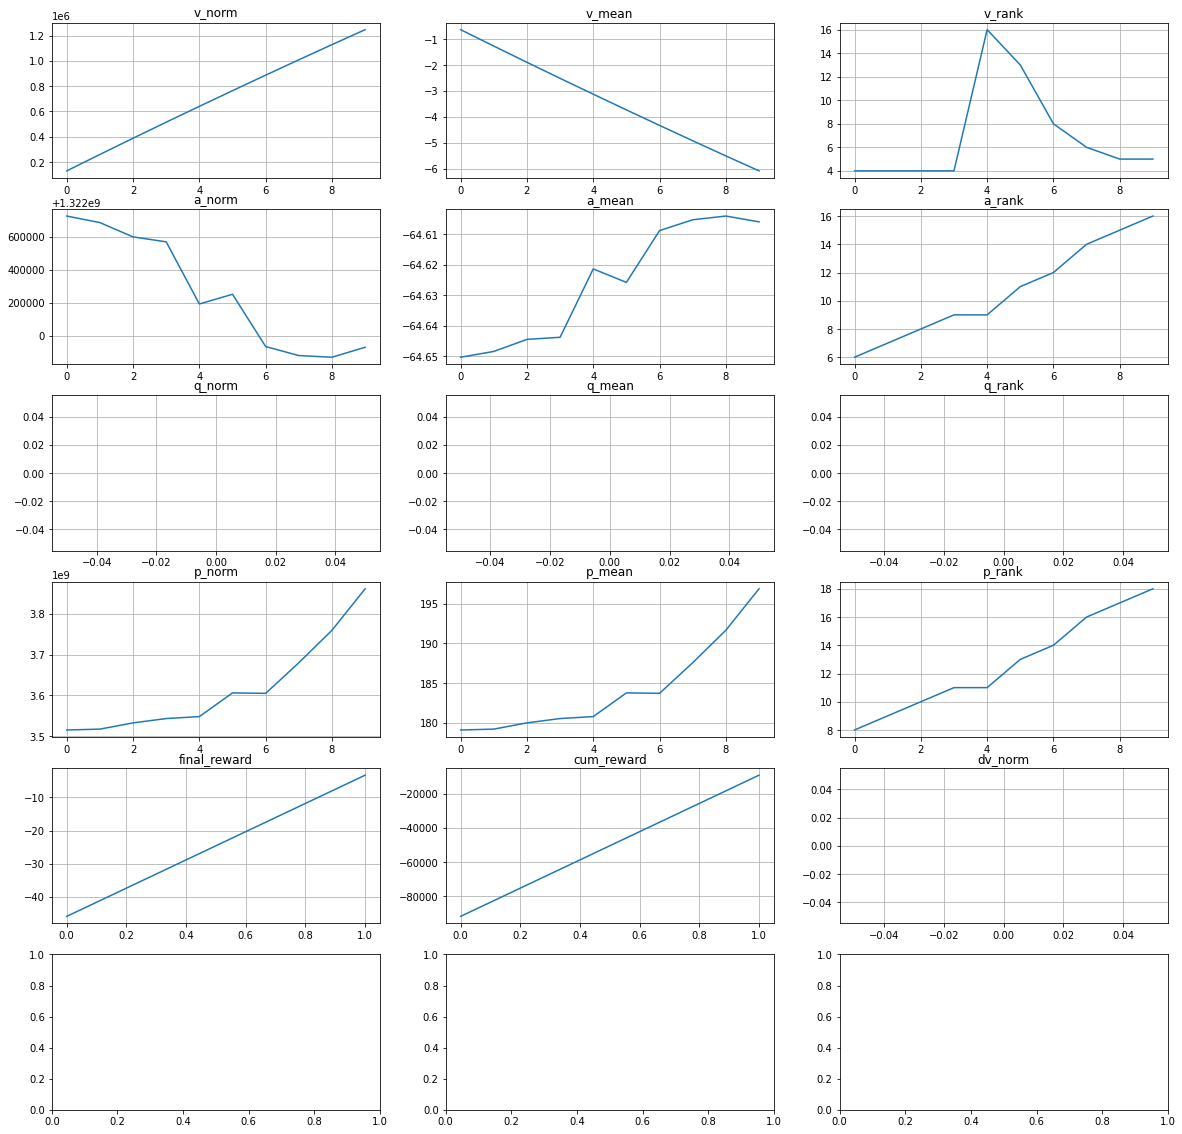

Memory:  0.001469952 0.048234496
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Policy Iteration 11/30
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Number of value updates:  1
.....................................................
Computing Advantage Fcn
.....................................................
v_min: -12.68, v_mean: -6.65, v_max: -0.06
a_min: -132.32, a_mean: -64.60, a_max: -0.40
p_min: 132.93, p_mean: 200.64, p_max: 264.85
Rank of V-model:  tensor([1, 5, 2, 3, 2, 1, 1])
Rank of A-model:  tensor([ 1,  6,  4,  8, 17, 15, 17, 11,  5,  1])
Rank of P-model:  tensor([ 1,  8,  6, 10, 19, 17, 19, 13,  7,  1])
--------------------------------------------
Time taken:1.9335181713104248
--------------------------------------------
Memory:  0.001781248 0.006291456000000001
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Policy Iteration 12/30
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Number of value updates:  1
.....................................................
Computing Advantage Fcn
......

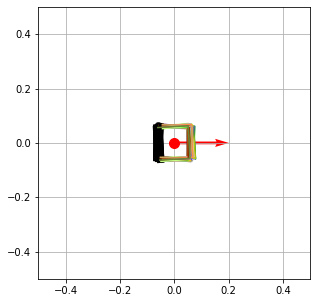

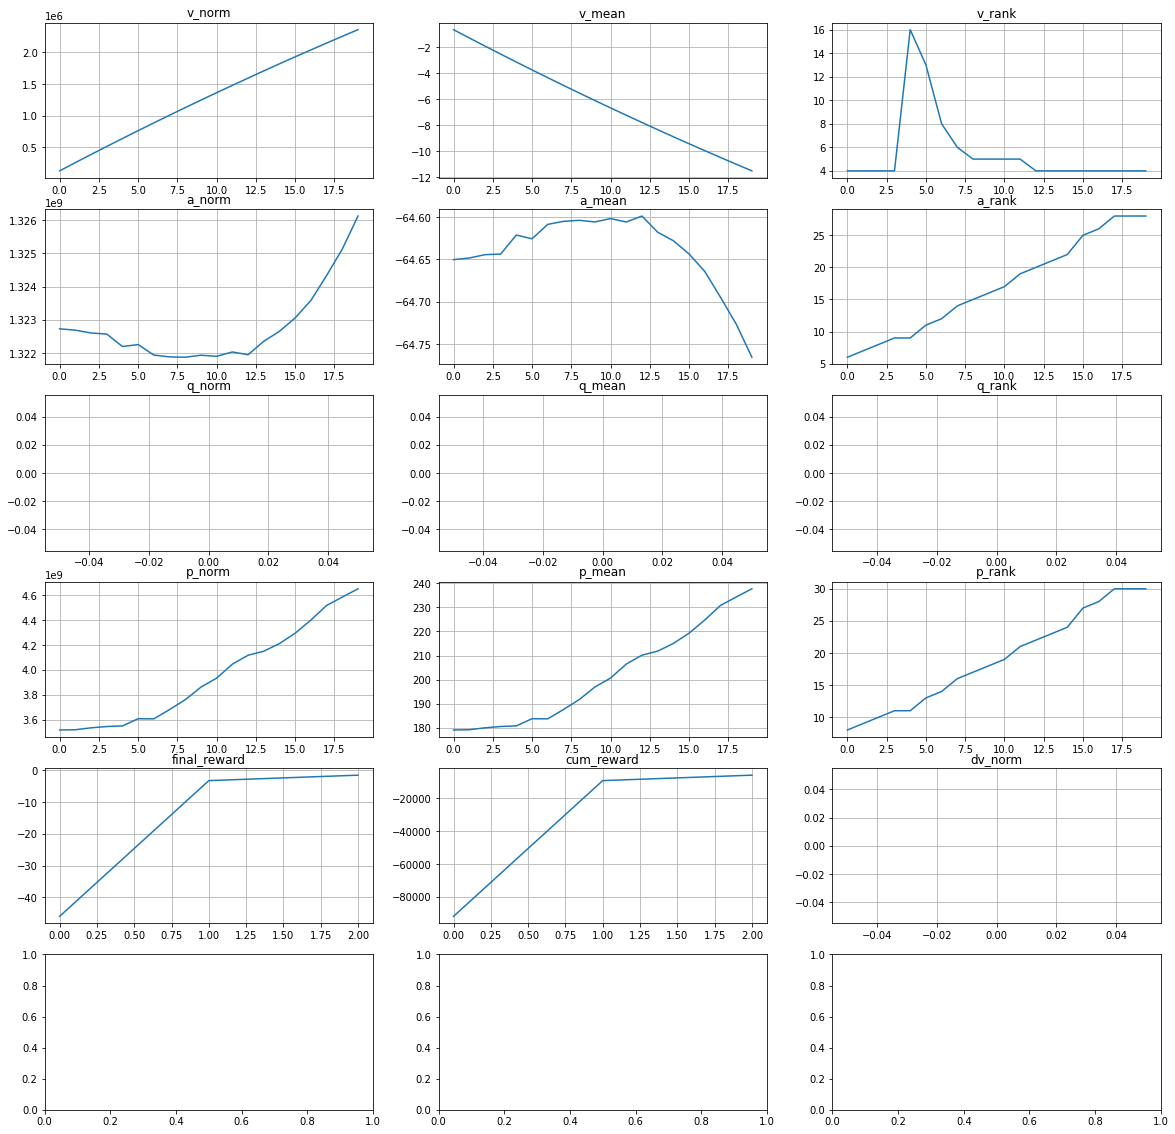

Memory:  0.0031585280000000003 0.052428800000000005
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Policy Iteration 21/30
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Number of value updates:  1
.....................................................
Computing Advantage Fcn
.....................................................
v_min: -23.03, v_mean: -12.00, v_max: -0.04
a_min: -151.99, a_mean: -64.81, a_max: 1.04
p_min: 154.04, p_mean: 241.22, p_max: 307.07
Rank of V-model:  tensor([1, 4, 2, 3, 3, 1, 1])
Rank of A-model:  tensor([ 1,  8,  5, 10, 29, 22, 25, 19,  6,  1])
Rank of P-model:  tensor([ 1, 10,  7, 12, 31, 24, 27, 21,  8,  1])
--------------------------------------------
Time taken:3.457400321960449
--------------------------------------------
Memory:  0.003412992 0.006291456000000001
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Policy Iteration 22/30
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Number of value updates:  1
.....................................................
Computing Ad

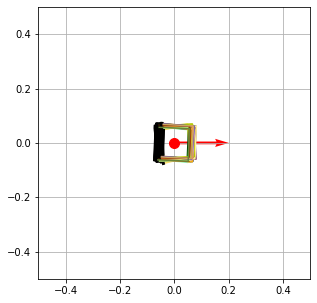

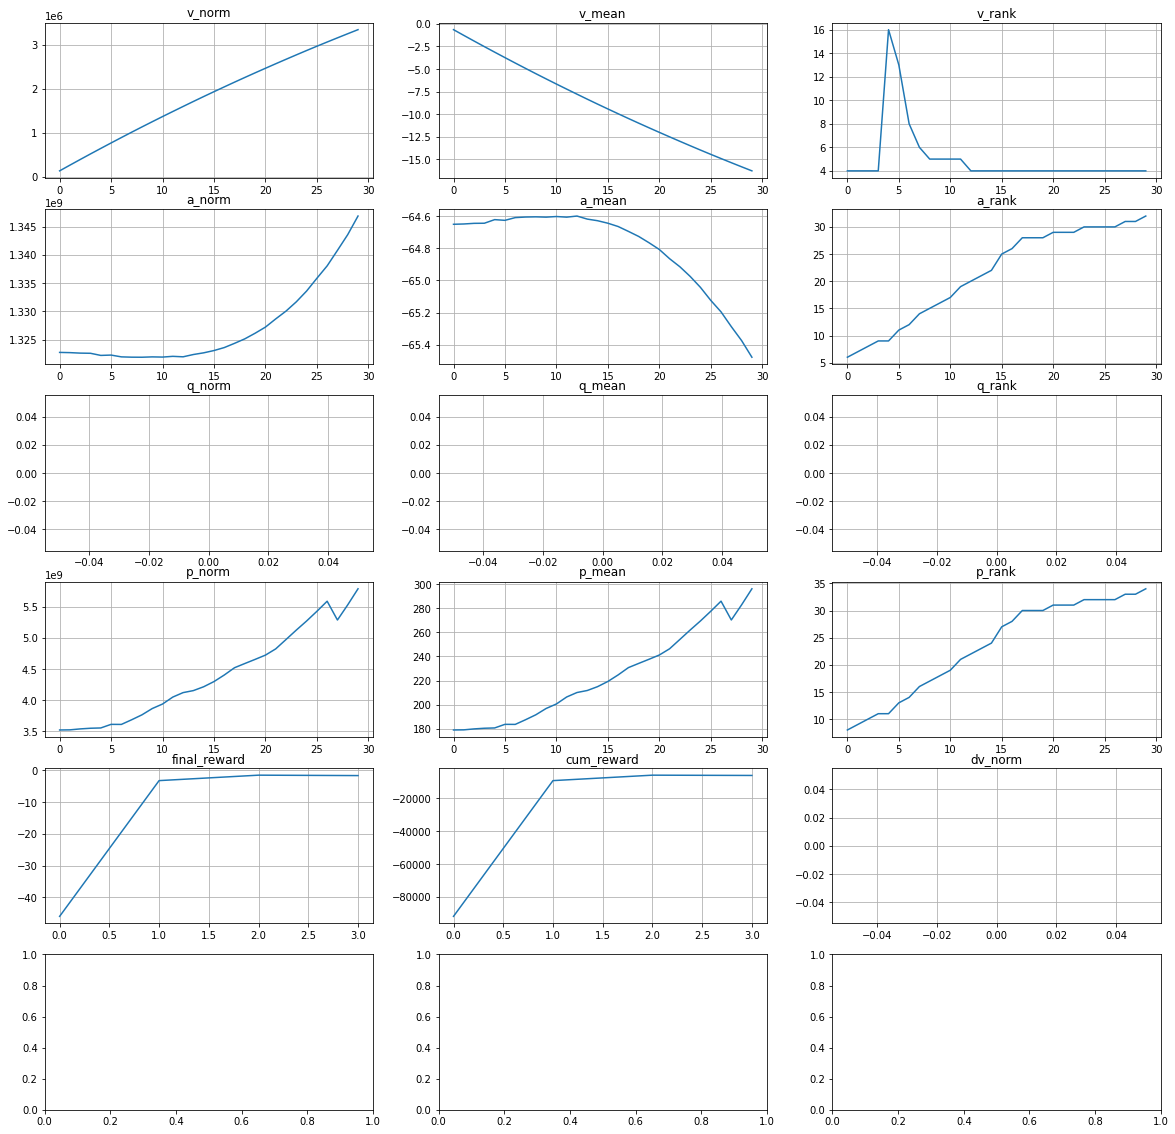

In [10]:
resume= False
ttpi.train(n_iter_max=30,n_iter_v=1,
        callback=callback, callback_freq=10,
        verbose=False, file_name='ttpi_pushing')


"